# Baselines for cross-dataset study

In this notebook, we train the ERGO II, NetTCR-2.0 and LUPI-SVM on the `α+β set` and test on the `β set`.

## Utility functions

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm import trange
import random

from tcrmodels.ergo2.model import ERGO2
from tcrmodels.nettcr2.model import NetTCR2

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from matplotlib import collections
from matplotlib import colors
from numpy.random import normal

Using TensorFlow backend.


In [2]:
metrics = [
    'AUROC',
    'Accuracy',
    #'Recall',
    'Precision',
    'F1 score',
    'AUPRC'
]

def pr_auc(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    return pr_auc

def get_scores(y_true, y_prob, y_pred):
    """
    Compute a df with all classification metrics and respective scores.
    """
    
    scores = [
        roc_auc_score(y_true, y_prob),
        accuracy_score(y_true, y_pred),
        #recall_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        f1_score(y_true, y_pred),
        pr_auc(y_true, y_prob)
    ]
    
    df = pd.DataFrame(data={'score': scores, 'metrics': metrics})
    return df

In [3]:
blosum50_20aa = {
    'A': np.array((5,-2,-1,-2,-1,-1,-1,0,-2,-1,-2,-1,-1,-3,-1,1,0,-3,-2,0)),
    'R': np.array((-2,7,-1,-2,-4,1,0,-3,0,-4,-3,3,-2,-3,-3,-1,-1,-3,-1,-3)),
    'N': np.array((-1,-1,7,2,-2,0,0,0,1,-3,-4,0,-2,-4,-2,1,0,-4,-2,-3)),
    'D': np.array((-2,-2,2,8,-4,0,2,-1,-1,-4,-4,-1,-4,-5,-1,0,-1,-5,-3,-4)),
    'C': np.array((-1,-4,-2,-4,13,-3,-3,-3,-3,-2,-2,-3,-2,-2,-4,-1,-1,-5,-3,-1)),
    'Q': np.array((-1,1,0,0,-3,7,2,-2,1,-3,-2,2,0,-4,-1,0,-1,-1,-1,-3)),
    'E': np.array((-1,0,0,2,-3,2,6,-3,0,-4,-3,1,-2,-3,-1,-1,-1,-3,-2,-3)),
    'G': np.array((0,-3,0,-1,-3,-2,-3,8,-2,-4,-4,-2,-3,-4,-2,0,-2,-3,-3,-4)),
    'H': np.array((-2,0,1,-1,-3,1,0,-2,10,-4,-3,0,-1,-1,-2,-1,-2,-3,2,-4)),
    'I': np.array((-1,-4,-3,-4,-2,-3,-4,-4,-4,5,2,-3,2,0,-3,-3,-1,-3,-1,4)),
    'L': np.array((-2,-3,-4,-4,-2,-2,-3,-4,-3,2,5,-3,3,1,-4,-3,-1,-2,-1,1)),
    'K': np.array((-1,3,0,-1,-3,2,1,-2,0,-3,-3,6,-2,-4,-1,0,-1,-3,-2,-3)),
    'M': np.array((-1,-2,-2,-4,-2,0,-2,-3,-1,2,3,-2,7,0,-3,-2,-1,-1,0,1)),
    'F': np.array((-3,-3,-4,-5,-2,-4,-3,-4,-1,0,1,-4,0,8,-4,-3,-2,1,4,-1)),
    'P': np.array((-1,-3,-2,-1,-4,-1,-1,-2,-2,-3,-4,-1,-3,-4,10,-1,-1,-4,-3,-3)),
    'S': np.array((1,-1,1,0,-1,0,-1,0,-1,-3,-3,0,-2,-3,-1,5,2,-4,-2,-2)),
    'T': np.array((0,-1,0,-1,-1,-1,-1,-2,-2,-1,-1,-1,-1,-2,-1,2,5,-3,-2,0)),
    'W': np.array((-3,-3,-4,-5,-5,-1,-3,-3,-3,-3,-2,-3,-1,1,-4,-4,-3,15,2,-3)),
    'Y': np.array((-2,-1,-2,-3,-3,-1,-2,-3,2,-1,-1,-2,0,4,-3,-2,-2,2,8,-1)),
    'V': np.array((0,-3,-3,-4,-1,-3,-3,-4,-4,4,1,-3,1,-1,-3,-2,0,-3,-1,5))
}

def enc_list_bl_max_len(aas, blosum, max_seq_len):
    '''
    blosum encoding of a list of amino acid sequences with padding 
    to a max length

    parameters:
        - aa_seqs : list with AA sequences
        - blosum : dictionnary: key= AA, value= blosum encoding
        - max_seq_len: common length for padding
    returns:
        padded_aa_encoding : array of padded amino acids encoding
    '''
    encoding_len = len(blosum['A'])
    padded_aa_encoding = np.zeros((encoding_len * max_seq_len))
    
    # encode amino acids
    for i, aa in enumerate(aas):
        padded_aa_encoding[i*encoding_len:(i+1)*encoding_len] = blosum[aa]
        
    return padded_aa_encoding

In [4]:
# Abbasi et al. implementation of LUPI-SVM does not predict probabilities
# we should do Platt scaling to estimate probabilities of a SVM
# but since that would be a complx implementation, we use a sigmoid
from scipy.stats import logistic

def sigmoid(x):
    return logistic.cdf(x)

In [5]:
import os
login = os.getlogin( )
DATA_BASE = f"/home/{login}/Git/tcr/data/"
RESULTS_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/results/"
FIGURES_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/figures/"
# To run in github checkout of vibtcr, after `unzip data.zip` ...
DATA_BASE = os.path.join('..', '..', 'data')
RESULTS_BASE = os.path.join('.', 'results')
FIGURES_BASE = os.path.join('.', 'figures')

# NetTCR2.0 

In [6]:
%%capture

test_files = [
    ('β-set', pd.read_csv(os.path.join(DATA_BASE, "alpha-beta-splits", "beta.csv"))),
]

train_file = pd.read_csv(os.path.join(DATA_BASE, "alpha-beta-splits", "alpha-beta.csv"))
results_nettcr2 = []

for i in tqdm(range(5)):
    model = NetTCR2(
        architecture="b", 
        single_chain_column='tcrb',
        peptide_column='peptide',
        label_column='sign',
        max_pep_len=max(
            train_file.peptide.str.len().max(), 
            test_files[0][1].peptide.str.len().max(),
        ),
        max_cdr3_len=max(
            train_file.tcrb.str.len().max(), 
            test_files[0][1].tcrb.str.len().max(),
        )
    )
    model.train(train_file, epochs=1000);

    for test_file in test_files:
        prediction_df = model.test(test_file[1])
        scores_df = get_scores(
            y_true=prediction_df['sign'].to_numpy(), 
            y_prob=prediction_df['prediction'].to_numpy(),
            y_pred=prediction_df['prediction'].to_numpy().round(),
        )
        scores_df['experiment'] = "train_α+β-set(β-only)_test_"+test_file[0]
        results_nettcr2.append(scores_df)
        test_file[1]['prediction_'+str(i)] = prediction_df['prediction']
        
results_nettcr2_df = pd.concat(results_nettcr2)

# save results for further analysis
for test_file in test_files:
    test_file[1].to_csv(os.path.join(RESULTS_BASE, "nettcr2.ab2b.csv"), index=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



# ERGO II

In [7]:
%%capture

test_files = [
    ['β-set', pd.read_csv(os.path.join(DATA_BASE, "alpha-beta-splits", "beta.csv"))],
]

train_file = pd.read_csv(os.path.join(DATA_BASE, "alpha-beta-splits", "alpha-beta.csv"))

# the ERGO II implementation expected the following columns to be preset in the dataframe
# even if they are not used
test_files[0][1]['va'] = pd.NA
train_file['va'] = pd.NA
test_files[0][1]['vb'] = pd.NA
train_file['vb'] = pd.NA
test_files[0][1]['ja'] = pd.NA
train_file['ja'] = pd.NA
test_files[0][1]['jb'] = pd.NA
train_file['jb'] = pd.NA
test_files[0][1]['mhc'] = pd.NA
train_file['mhc'] = pd.NA
test_files[0][1]['t_cell_type'] = pd.NA
train_file['t_cell_type'] = pd.NA
test_files[0][1]['protein'] = pd.NA
train_file['protein'] = pd.NA

# using "UNK" for identifier of missing CDR3α for test set
test_files[0][1]['tcra'] = "UNK"

# the ERGO II data presents some files with a given header, and some others with a different one
map_keys = {
    'tcra': 'TRA',
    'tcrb': 'TRB',
    'va': 'TRAV',
    'ja': 'TRAJ',
    'vb': 'TRBV',
    'jb': 'TRBJ',
    't_cell_type': 'T-Cell-Type',
    'peptide': 'Peptide',
    'mhc': 'MHC',
    'protein': 'protein',
    'sign': 'sign'
}
test_files[0][1] = test_files[0][1].rename(columns={c: map_keys[c] for c in test_files[0][1].columns})

results_ergo2 = []

for i in tqdm(range(5)):
    model = ERGO2(
        gpu=[0],
        use_alpha=False,
        random_seed=i,
        train_val_ratio=.2,
    )
    model.train(train_file);

    for test_file in test_files:
        prediction_df = model.test(test_file[1])
        scores_df = get_scores(
            y_true=prediction_df['sign'].to_numpy(), 
            y_prob=prediction_df['prediction'].to_numpy(),
            y_pred=prediction_df['prediction'].to_numpy().round(),
        )
        scores_df['experiment'] = "train_α+β-set(β-only)_test_"+test_file[0]
        results_ergo2.append(scores_df)
        test_file[1]['prediction_'+str(i)] = prediction_df['prediction']
        
results_ergo2_df = pd.concat(results_ergo2)

# save results for further analysis
for test_file in test_files:
    test_file[1].to_csv(os.path.join(RESULTS_BASE, "ergo2.ab2b.csv"), index=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type         | Params
-----------------------------------------------
0 | tcrb_encoder  | LSTM_Encoder | 3 M   
1 | pep_encoder   | LSTM_Encoder | 3 M   
2 | hidden_layer1 | Linear       | 31 K  
3 | relu          | LeakyReLU    | 0     
4 | output_layer1 | Linear       | 32    
5 | dropout       | Dropout      | 0     
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type         | Params
-----------------------------------------------
0 | tcrb_encoder  | LSTM_Encoder | 3 M   
1 | pep_encoder   | LSTM_Encoder | 3 M   
2 | hidden_layer1 | Linear       | 31 K  
3 | relu          | LeakyReLU    | 0     
4 | output_layer1 | Linear       | 32    
5 | dropout       | Dropout      | 0     
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name        

# LUPI-SVM
Learning protein binding affinity using privileged information, Abbasi et al., BMC Bioinformatics, 2018

Paper: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2448-z

Code: https://github.com/wajidarshad/LUPI-SVM

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 20 00:59:45 2017

@author: Wajid Arshad Abbasi

This module contains the class definitions for the Stochastic subgradient descent based large margin classifiers for Learning Using Privileged Information (LUPI)

"""
class ClassifierBase:
    """
    This is the base class for LUPI
    """
    
    def __init__(self,**kwargs):
    
        if 'epochs' in kwargs:
            self.epochs=kwargs['epochs']
        else:
            self.epochs=100
        if 'Lambda' in kwargs:
            self.Lambda=kwargs['Lambda']
        else:
            self.Lambda=0.01
        if 'Lambda_star' in kwargs:
            self.Lambda_star=kwargs['Lambda_star']
        else:
            self.Lambda_star=0.01
        if 'Lambda_s' in kwargs:
            self.Lambda_s=kwargs['Lambda_s']
        else:
            self.Lambda_s=0.001
        self.w=None
        self.w_star=None
        self.Name=None
        
    def fit(self,bags,**kwargs):
        pass
        
        
    def predict_score(self,test_example):
        w=self.w
        pred_score=test_example.dot(w.T)
        return pred_score
    def save(self,ofname):
        with open(ofname,'w') as fout:
            fout.write(self.toString())
    def load(self,ifname):
        with open(ifname) as fin:
           self.fromString(fin.read())         
    def toString(self):
        import json
        s='#Name='+str(self.__class__)
        s+='#w='+str(json.dumps(self.w.tolist()))
        s+='#w_star='+str(json.dumps(self.w_star.tolist()))
        s+='#Epochs='+str(self.epochs)  
        s+='#Lambda='+str(self.Lambda)
        s+='#Lambda_star='+str(self.Lambda_star)
        s+='#Lambda_s='+str(self.Lambda_s)
        return s
        
    def fromString(self,s):    
        import json
        for token in s.split('#'):
            if token.find('w=')>=0 or token.find('W=')>=0:
                self.w=np.array(json.loads(token.split('=')[1]))
            if token.find('w_star=')>=0 or token.find('W_star=')>=0:
                self.w_star=np.array(json.loads(token.split('=')[1]))
            elif token.find('Epochs=')>=0:
                self.epochs=float(token.split('=')[1]) 
            elif token.find('Lambda_star=')>=0:
                self.Lambda_star=float(token.split('=')[1])
            elif token.find('Lambda=')>=0:
                self.Lambda=float(token.split('=')[1])
            elif token.find('Lambda_s=')>=0:
                self.Lambda_s=float(token.split('=')[1])

#############################################################################################

class linclassLUPI(ClassifierBase):   
    """
    This class defines the stochastic gradient descent based linear large margin classifier for LUPI.

    Parent Class: ClassifierBase
    
    Properties:
    epochs: No. of epochs to be run for optimization
    Lambda, Lambda_satr and Lambda_s: The Regularization Hyperparameters
    
    Methods:
    train(dataset)
    predict(example)
    load(filename)
    save(filename)
    
    USAGE
    Class definition:
    clf=linclassLUPI() # create a classifier object with default arguments epochs=100, Lambda=0.01, Lambda_star=0.01, Lambda_s=0.001
    clf=linclassLUPI(epochs=100, Lambda=0.01,Lambda_star=0.1,Lambda_s=0.001) # create a classifier object with customized arguments
    
    Training:
    clf.fit(clf.train([[[x1],[X1*],y1],[x2],[X2*],y2],[x3],[X3*],y3],....[Xn],[Xn*],yn]])) where X:Input Feature Space, X*: Privileged Feature Space and y: Labels
    
    Predict:
    clf.predict_score([[X_test1],[X_test2]]) X_test: test examples only input feature space
    
    Load Classifier:
    clf.load(filename)
    
    Save Classifier:
    clf.save(filename)
    """
    
    def fit(self, dataset,**kwargs):
        
        siz1=np.shape(dataset[0][0])[0]
        siz2=np.shape(dataset[0][1])[0]
        w=np.array(np.zeros(siz1))  
        w_star=np.array(np.zeros(siz2))
        T=(len(dataset))*self.epochs
        for t in trange(T):
            mue=1.0/(self.Lambda*(t+1))
            mue_star=1.0/(self.Lambda_star*(t+1))
            update_w=False
            update_w_star=False
            if (t)%self.epochs==0:
                np.random.shuffle(dataset)
            instance_chosen=dataset[(t-1)%len(dataset)]
            if 1-instance_chosen[2]*(instance_chosen[0].dot(w.T))-instance_chosen[2]*(instance_chosen[1].dot(w_star.T))>0 and 1-instance_chosen[2]*(instance_chosen[0].dot(w.T))>0:
                update_w=True
            if -instance_chosen[2]*(instance_chosen[1].dot(w_star.T))>0 or 1-instance_chosen[2]*(instance_chosen[0].dot(w.T))-instance_chosen[2]*(instance_chosen[1].dot(w_star.T))>0:
                update_w_star=True
            if update_w:
                w=((1-(1.0/(t+1)))*w)+(mue*(instance_chosen[2]*instance_chosen[0]))
            else:
                w=((1-(1.0/(t+1)))*w)
            if update_w_star:
                w_star=((1-(1.0/(t+1)))*w_star)-(mue_star*self.Lambda_s*(instance_chosen[2]*instance_chosen[1]))+(mue_star*(instance_chosen[2]*instance_chosen[1]))
            else:
                w_star=((1-(1.0/(t+1)))*w_star)-(mue_star*self.Lambda_s*(instance_chosen[2]*instance_chosen[1]))
        self.w=w
        self.w_star=w_star

#####################################################################################################################################

In [9]:
test_files = [
    ['β-set', pd.read_csv(os.path.join(DATA_BASE, "alpha-beta-splits", "beta.csv"))],
]

train_file = pd.read_csv(os.path.join(DATA_BASE, "alpha-beta-splits", "alpha-beta.csv"))

max_tcra_len = train_file.tcra.str.len().max()
train_file['tcra'] = train_file['tcra'].apply(lambda x: enc_list_bl_max_len(x, blosum50_20aa, max_tcra_len))

max_tcrb_len = max(train_file.tcrb.str.len().max(), test_files[0][1].tcrb.str.len().max())
train_file['tcrb'] = train_file['tcrb'].apply(lambda x: enc_list_bl_max_len(x, blosum50_20aa, max_tcrb_len))
test_files[0][1]['tcrb'] = test_files[0][1]['tcrb'].apply(lambda x: enc_list_bl_max_len(x, blosum50_20aa, max_tcrb_len))

max_pep_len = max(train_file.peptide.str.len().max(), test_files[0][1].peptide.str.len().max())
train_file['peptide'] = train_file['peptide'].apply(lambda x: enc_list_bl_max_len(x, blosum50_20aa, max_pep_len))
test_files[0][1]['peptide'] = test_files[0][1]['peptide'].apply(lambda x: enc_list_bl_max_len(x, blosum50_20aa, max_pep_len))

In [10]:
X_privileged = np.stack(train_file.tcra.to_list(), axis=0)

tcrb = np.stack(train_file.tcrb.to_list(), axis=0)
peptides = np.stack(train_file.peptide.to_list(), axis=0)
X_train = np.concatenate([tcrb, peptides], axis=1)

tcrb = np.stack(test_files[0][1].tcrb.to_list(), axis=0)
peptides = np.stack(test_files[0][1].peptide.to_list(), axis=0)
X_test = np.concatenate([tcrb, peptides], axis=1)

y_train = np.stack(train_file.sign.to_list(), axis=0)

y_test = np.stack(test_files[0][1].sign.to_list(), axis=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_privileged = scaler.fit_transform(X_privileged)

In [11]:
clf=linclassLUPI(epochs=1000, Lambda=0.1,Lambda_star=0.01,Lambda_s=0.001)
LUPI_train_data = list(zip(X_train, X_privileged, y_train))
clf.fit(LUPI_train_data)
clf.save(os.path.join(RESULTS_BASE, "trained-lupi-svm.skl"))

100%|██████████| 107775000/107775000 [1:28:13<00:00, 20361.37it/s]


In [12]:
clf=linclassLUPI(epochs=1000, Lambda=0.1,Lambda_star=0.01,Lambda_s=0.001)
clf.load(os.path.join(RESULTS_BASE, "trained-lupi-svm.skl"))
y_decision_function = clf.predict_score(X_test)
y_prob = sigmoid(y_decision_function)  # should be Platt scaling
y_pred = np.sign(y_decision_function).clip(min=0)
scores_df = get_scores(y_test, y_prob, y_pred)
test_files = [
    ['β-set', pd.read_csv(os.path.join(DATA_BASE, "alpha-beta-splits", "beta.csv"))],
]

test_files[0][1]['prediction_0'] = list(y_decision_function)

# save results for further analysis
for test_file in test_files:
    test_files[0][1].to_csv(
        os.path.join(RESULTS_BASE, "lupi-svm.ab2b.csv"),
        index=False
    )

# Figures

100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


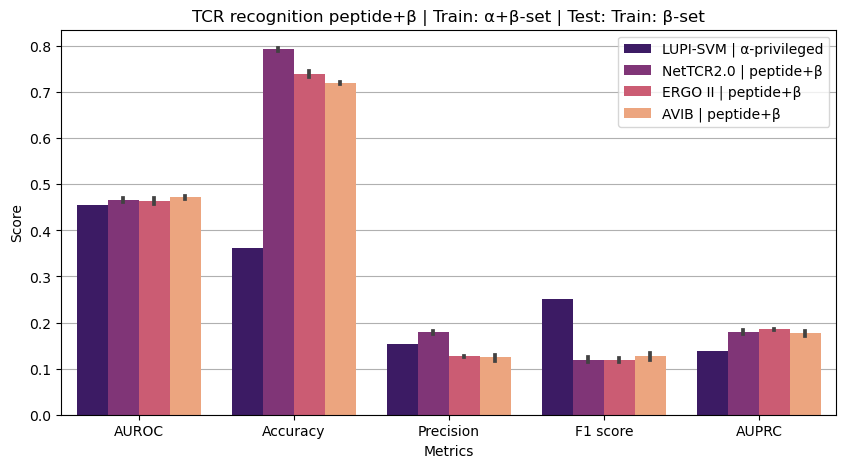

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

predictions_files = [
    ('LUPI-SVM | α-privileged', pd.read_csv(os.path.join(RESULTS_BASE, "lupi-svm.ab2b.csv"))),
    ('NetTCR2.0 | peptide+β',   pd.read_csv(os.path.join(RESULTS_BASE, "nettcr2.ab2b.csv"))),
    ('ERGO II | peptide+β',     pd.read_csv(os.path.join(RESULTS_BASE, "ergo2.ab2b.csv"))),
    #('RF-HPO',                 pd.read_csv(os.path.join(RESULTS_BASE, "rf-hpo.ab2b.csv"))),
    #('PVIB | α-privileged',    pd.read_csv(os.path.join(RESULTS_BASE, "pvib.ab2b.csv"))),
    ('AVIB | peptide+β',        pd.read_csv(os.path.join(RESULTS_BASE, "mvib.ab2b.csv"))),
]

results = []

for i in tqdm(range(5)):
    for predictions_file in predictions_files:
        prediction_df = predictions_file[1]
        if f'prediction_{i}' in prediction_df.columns:
            if "LUPI-SVM" in predictions_file[0]:
                scores_df = get_scores(
                    y_true=prediction_df['sign'].to_numpy(), 
                    y_prob=sigmoid(prediction_df[f'prediction_{i}'].to_numpy()),
                    y_pred=np.sign(prediction_df[f'prediction_{i}'].to_numpy().round()).clip(min=0),
                )
            else:
                scores_df = get_scores(
                    y_true=prediction_df['sign'].to_numpy(), 
                    y_prob=prediction_df[f'prediction_{i}'].to_numpy(),
                    y_pred=prediction_df[f'prediction_{i}'].to_numpy().round(),
                )
            scores_df['Model'] = predictions_file[0]
            results.append(scores_df)

results_df = pd.concat(results).rename(columns={'metrics': 'Metrics', 'score': 'Score'})

plt.rcParams['figure.figsize'] = [10, 5]

ax = sns.barplot(
    x="Metrics",
    y="Score", 
    hue="Model", 
    data=results_df,
    palette=sns.color_palette("magma", len(predictions_files)),
)

ax.set_title('TCR recognition peptide+β | Train: α+β-set | Test: Train: β-set')
ax.legend(loc='best')
legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
ax.grid(axis='y')
ax.set_axisbelow(True)

plt.savefig(os.path.join(FIGURES_BASE, "baseline.ab2b.svg"), format='svg', dpi=300)
plt.savefig(os.path.join(FIGURES_BASE, "baseline.ab2b.png"), format='png', dpi=300)

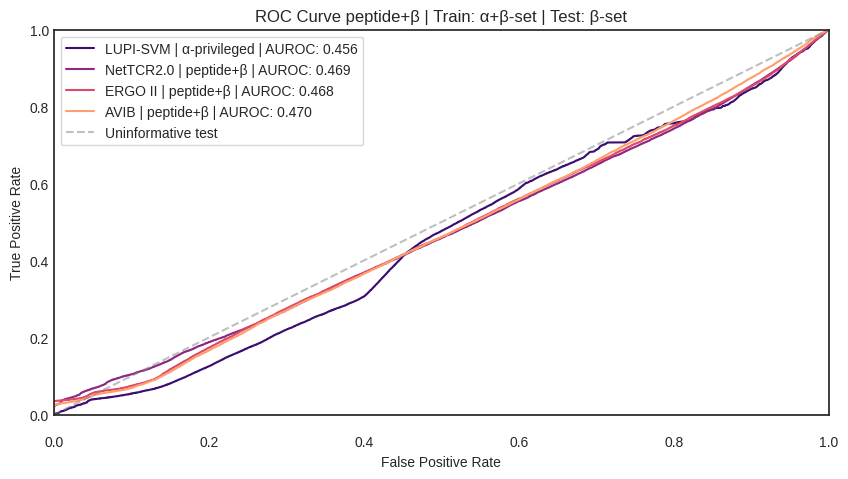

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-white')
sns.set_palette('magma', len(predictions_files))

def make_roc_curve_plot(ax, true_values, predicted_values, cutoff, model_label):
    """Calculate ROC and AUC from true and predicted values and draw."""

    fpr, tpr, thresholds = roc_curve(true_values, predicted_values)
    auc = roc_auc_score(true_values, predicted_values)
    
    ax.plot(fpr, tpr, label=model_label+str(f" | AUROC: {auc:.3f}"))
    ax.set_title("ROC Curve peptide+β | Train: α+β-set | Test: β-set")
    
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    
    ax.legend()
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    
#     for fp, tp, threshold in zip(fpr, tpr, thresholds):
#         if threshold < cutoff:
#             ax.plot(fp, tp, marker='o', markersize=10, color='grey', alpha=0.75)
#             break

def make_uninformative_roc(ax):
    ax.plot([0, 1], [0, 1], c='grey', linestyle='dashed', alpha=0.5, label="Uninformative test")
    ax.legend()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(facecolor="white")

predictions_files = [
    ('LUPI-SVM | α-privileged', pd.read_csv(os.path.join(RESULTS_BASE, "lupi-svm.ab2b.csv"))),
    ('NetTCR2.0 | peptide+β',   pd.read_csv(os.path.join(RESULTS_BASE, "nettcr2.ab2b.csv"))),
    ('ERGO II | peptide+β',     pd.read_csv(os.path.join(RESULTS_BASE, "ergo2.ab2b.csv"))),
    #('RF-HPO',                 pd.read_csv(os.path.join(RESULTS_BASE, "rf-hpo.ab2b.csv"))),
    #('PVIB | α-privileged',    pd.read_csv(os.path.join(RESULTS_BASE, "pvib.ab2b.csv"))),
    ('AVIB | peptide+β',        pd.read_csv(os.path.join(RESULTS_BASE, "mvib.ab2b.csv"))),
]

fig, ax = plt.subplots()

for predictions_file in predictions_files:
    prediction_df = predictions_file[1]
    if "RF-HPO" in predictions_file[0]:
        make_roc_curve_plot(
            ax, 
            prediction_df['sign'].to_numpy(), 
            prediction_df[f'prediction_0'].to_numpy(), 0.9,
            predictions_file[0]
        )
    elif "LUPI-SVM" in predictions_file[0]:
        make_roc_curve_plot(
            ax, 
            prediction_df['sign'].to_numpy(), 
            sigmoid(prediction_df[f'prediction_0'].to_numpy()), 0.9,
            predictions_file[0]
        )
    else:
        pred = prediction_df[f'prediction_0'].to_numpy() + \
        prediction_df[f'prediction_1'].to_numpy() + \
        prediction_df[f'prediction_2'].to_numpy() + \
        prediction_df[f'prediction_3'].to_numpy() + \
        prediction_df[f'prediction_4'].to_numpy()
        pred /= 5
        make_roc_curve_plot(
            ax, 
            prediction_df['sign'].to_numpy(), 
            pred, 0.9,
            predictions_file[0]
        )
make_uninformative_roc(ax)
ax.tick_params(axis='x', pad=15)
legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.savefig(os.path.join(FIGURES_BASE, "roc.ab2b.svg"), format='svg', dpi=300)
plt.savefig(os.path.join(FIGURES_BASE, "roc.ab2b.png"), format='png', dpi=300)

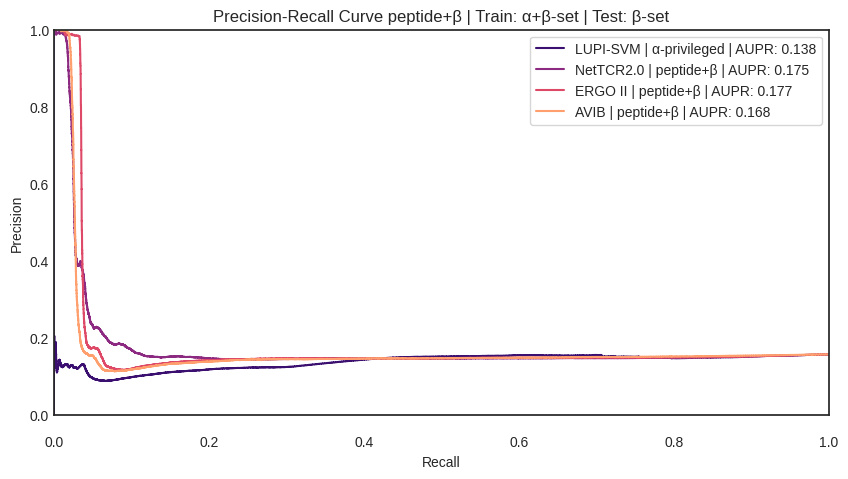

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def make_prc_curve_plot(ax, true_values, predicted_values, model_label):
    """Calculate PRC and AUC from true and predicted values and draw."""

    precision, recall, thresholds = precision_recall_curve(true_values, predicted_values)
    auc = pr_auc(true_values, predicted_values)
    
    ax.plot(recall, precision, label=model_label+str(f" | AUPR: {auc:.3f}"))
    ax.set_title("Precision-Recall Curve peptide+β | Train: α+β-set | Test: β-set")
    
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    
    ax.legend()
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])

predictions_files = [
    ('LUPI-SVM | α-privileged', pd.read_csv(os.path.join(RESULTS_BASE, "lupi-svm.ab2b.csv"))),
    ('NetTCR2.0 | peptide+β',   pd.read_csv(os.path.join(RESULTS_BASE, "nettcr2.ab2b.csv"))),
    ('ERGO II | peptide+β',     pd.read_csv(os.path.join(RESULTS_BASE, "ergo2.ab2b.csv"))),
    #('RF-HPO',                 pd.read_csv(os.path.join(RESULTS_BASE, "rf-hpo.ab2b.csv"))),
    #('PVIB | α-privileged',    pd.read_csv(os.path.join(RESULTS_BASE, "pvib.ab2b.csv"))),
    ('AVIB | peptide+β',        pd.read_csv(os.path.join(RESULTS_BASE, "mvib.ab2b.csv"))),
]

fig, ax = plt.subplots()

for predictions_file in predictions_files:
    prediction_df = predictions_file[1]
    if "RF-HPO" in predictions_file[0]:
        make_prc_curve_plot(
            ax, 
            prediction_df['sign'].to_numpy(), 
            prediction_df[f'prediction_0'].to_numpy(),
            predictions_file[0]
        )
    elif "LUPI-SVM" in predictions_file[0]:
        make_prc_curve_plot(
            ax, 
            prediction_df['sign'].to_numpy(), 
            sigmoid(prediction_df[f'prediction_0'].to_numpy()),
            predictions_file[0]
        )    
    else:
        pred = prediction_df[f'prediction_0'].to_numpy() + \
        prediction_df[f'prediction_1'].to_numpy() + \
        prediction_df[f'prediction_2'].to_numpy() + \
        prediction_df[f'prediction_3'].to_numpy() + \
        prediction_df[f'prediction_4'].to_numpy()
        pred /= 5
        make_prc_curve_plot(
            ax, 
            prediction_df['sign'].to_numpy(), 
            pred,
            predictions_file[0]
        )

ax.tick_params(axis='x', pad=15)
legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.savefig(os.path.join(FIGURES_BASE, "prc.ab2b.svg"), format='svg', dpi=300)
plt.savefig(os.path.join(FIGURES_BASE, "prc.ab2b.png"), format='png', dpi=300)